In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE

In [3]:
import os
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/BIS550")

In [4]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

In [5]:
import pandas as pd

IG_P = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/BIS550/Code by message type.xlsx', sheet_name='Info Giving - Patient')
IG_C = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/BIS550/Code by message type.xlsx', sheet_name='Info Giving - Clinician')
IG_A = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/BIS550/Code by message type.xlsx', sheet_name='Info Giving - Auto')

IS_C = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/BIS550/Code by message type.xlsx', sheet_name='Info Seek - Clinician')
IS_P = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/BIS550/Code by message type.xlsx', sheet_name='Info Seek - Patient')

Emo_P = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/BIS550/Code by message type.xlsx', sheet_name='Emotion - Patient')
Emo_C = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/BIS550/Code by message type.xlsx', sheet_name='Emotion - Clinician')

P_C = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/BIS550/Code by message type.xlsx', sheet_name='Partnership - Clinician')
P_P = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/BIS550/Code by message type.xlsx', sheet_name='Partnership - Patient')

In [6]:
# Combine IG_P, IG_C, IG_A into one dataframe
IG = pd.concat([IG_P, IG_C, IG_A], axis=0, ignore_index=True)
IG
# Combine IS_C, IS_P into one dataframe
IS = pd.concat([IS_C, IS_P], axis=0, ignore_index=True)

# Combine Emo_P, Emo_C into one dataframe
Emo = pd.concat([Emo_P, Emo_C], axis=0, ignore_index=True)

# Combine P_C, P_P into one dataframe
P = pd.concat([P_C, P_P], axis=0, ignore_index=True)


In [7]:
# Add labels to each dataframe
IG['Label'] = 'Info Giving'
IS['Label'] = 'Info Seeking'
Emo['Label'] = 'Emotion'
P['Label'] = 'Partnership'

# Combine all dataframes into one dataframe
df = pd.concat([IG, IS, Emo, P], axis=0, ignore_index=True)
df

,Quotation Content,Codes,Label
0,197 I noticed that my medication list has not ...,Patient,Info Giving
1,Blood in urine and stool- began yesterday We a...,Patient,Info Giving
2,Can someone set up that appointment as I do no...,Patient,Info Giving
3,Dear Doctor Lacy I just was told my daughter w...,Patient,Info Giving
4,Dear Dr Chiang When I saw you last Thursday( M...,Patient,Info Giving
...,...,...,...
265,Hi Dr Tara: When we spoke a week or so ago you...,Patient,Partnership
266,Hi Dr: Can you provide us with the results of ...,Patient,Partnership
267,Only 4 left Has renewal been sent in How can w...,Patient,Partnership
268,Dear Dr Chiang When I saw you last Thursday( M...,Patient,Partnership


In [8]:
%pip install nltk


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import nltk
nltk.download('punkt')
df = df[df['Quotation Content'].notna()]
sent_count,word_count= get_sentence_word_count(df['Quotation Content'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))


data_categories  = df.groupby(df['Label'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 10)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['Label'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Number of sentences in transcriptions column: 270
Number of unique words in transcriptions column: 1537
===========Original Categories =======================
Cat:1 Emotion : 32
Cat:2 Info Giving : 159
Cat:3 Info Seeking : 61
Cat:4 Partnership : 18
============Reduced Categories ======================
Cat:1 Emotion : 32
Cat:2 Info Giving : 159
Cat:3 Info Seeking : 61
Cat:4 Partnership : 18
============ Reduced Categories ======================


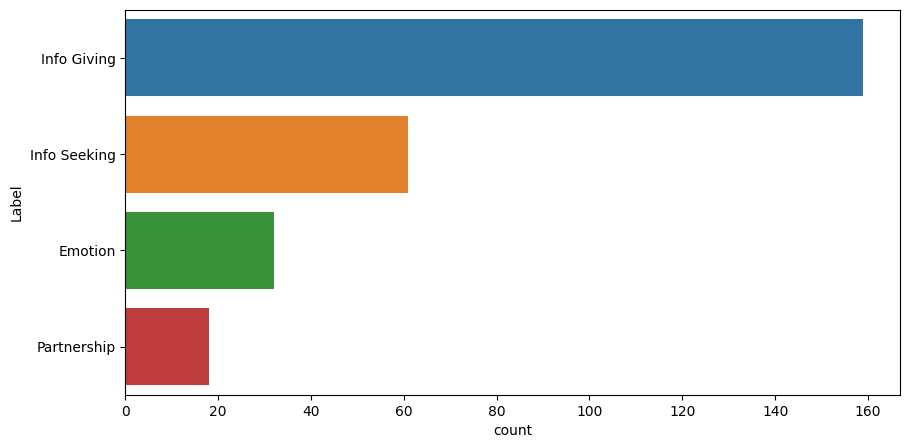

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(y='Label', data = filtered_data_categories )
plt.show()

In [11]:
def clean_text(text): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist) 

In [12]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

data = df
data['Quotation Content'] = data['Quotation Content'].apply(lemmatize_text)
data['Quotation Content'] = data['Quotation Content'].apply(clean_text)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['Quotation Content'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)

['able', 'admin', 'afternoon', 'afternoon appointment', 'afternoon appointment dr', 'afternoon wa', 'afternoon wa good', 'ago', 'android', 'android prepare', 'android prepare lt', 'anxious', 'app', 'app phone', 'app phone tablet', 'apple', 'apple prepare', 'apple prepare mychart', 'application', 'appointment', 'appointment dr', 'appointment dr yesterday', 'appointment information', 'appointment information department', 'appointment information visit', 'appointment medical', 'appointment medical surgical', 'appropriate', 'appropriate link', 'appropriate link help', 'approval', 'approved', 'appt', 'appt instructions', 'appt instructions make', 'appt status', 'appt status scheduled', 'april', 'april previous', 'april previous condition', 'arm', 'arm hand', 'arrival', 'arrive', 'ask', 'asked', 'aug', 'august', 'available', 'available questionnaire', 'available questionnaire flu', 'aware', 'begin', 'believe', 'best', 'bid', 'blood', 'blood test', 'blood work', 'bluetooth', 'bluetooth turned

<270x19 sparse matrix of type '<class 'numpy.float64'>'
	with 250 stored elements in Compressed Sparse Row format>

In [17]:
data['Quotation Content']

0       i noticed that my medication list ha not been...
1      blood in urine and stool began yesterday we al...
2      can someone set up that appointment a i do not...
3      dear doctor lacy i just wa told my daughter wi...
4      dear dr chiang when i saw you last thursday  m...
                             ...                        
265    hi dr tara  when we spoke a week or so ago you...
266    hi dr  can you provide u with the result of my...
267    only  left has renewal been sent in how can we...
268    dear dr chiang when i saw you last thursday  m...
269    i had my blood testing done yesterday at the i...
Name: Quotation Content, Length: 270, dtype: object

In [18]:
tfIdfMat.shape

(270, 1000)

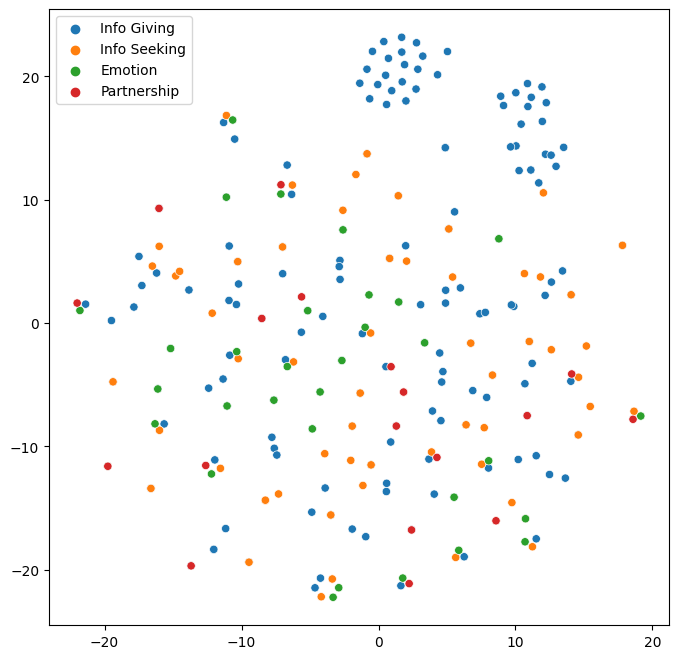

In [19]:
import gc
gc.collect()
tfIdfMatrix = np.asarray(tfIdfMat.todense())
labels = data['Label'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(8,8))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    legend="full",
    alpha=1
)
plt.show()

In [20]:
gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['Label'].tolist()
category_list = data.Label.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))   

Train_Set_Size:(202, 113)
Test_Set_Size:(68, 113)


In [21]:
tfIdfMat.toarray()[1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.61961576, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [22]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred)

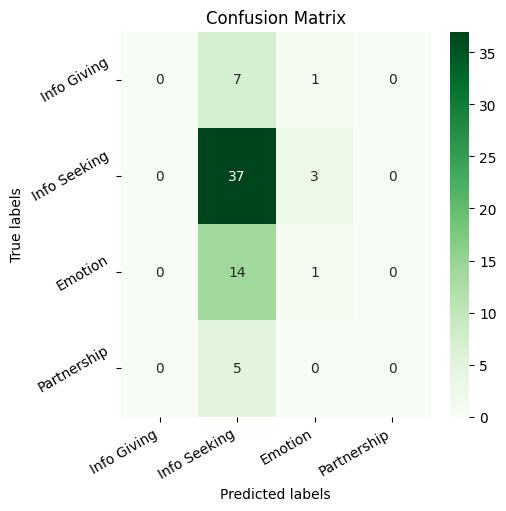

In [23]:
fig = plt.figure(figsize=(5,5))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [24]:
print(classification_report(y_test,y_test_pred,labels=category_list))

              precision    recall  f1-score   support

 Info Giving       0.59      0.93      0.72        40
Info Seeking       0.20      0.07      0.10        15
     Emotion       0.00      0.00      0.00         8
 Partnership       0.00      0.00      0.00         5

    accuracy                           0.56        68
   macro avg       0.20      0.25      0.20        68
weighted avg       0.39      0.56      0.44        68



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
%pip install scispacy
%pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bionlp13cg_md-0.5.1.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Uninstalling wasabi-1.1.1:
      Successfully uninstalled wasabi-1.1.1
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.2
    Uninstalling spacy-3.5.2:
      Successfully uninstalled spacy-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.5.0 requ

In [26]:
import spacy
import en_ner_bionlp13cg_md
nlp = en_ner_bionlp13cg_md.load()

In [27]:
def process_Text(text):
    wordlist=[]
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)     

In [28]:
data['Quotation Content'] = data['Quotation Content'].apply(process_Text)
data['Quotation Content'] = data['Quotation Content'].apply(lemmatize_text)
data['Quotation Content'] = data['Quotation Content'].apply(clean_text)

In [29]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['Quotation Content'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)

['arm', 'arm heart', 'blood', 'cancer', 'cell', 'colorectal', 'colorectal cancer', 'face', 'face gt', 'gt', 'heart', 'joint', 'left', 'let', 'liver', 'patient', 'patient face', 'patient face gt', 'tablet']


<ipython-input-30-44b8a4f45fdc>:8: UserWarning: The palette list has more values (12) than needed (4), which may not be intended.
  sns.scatterplot(


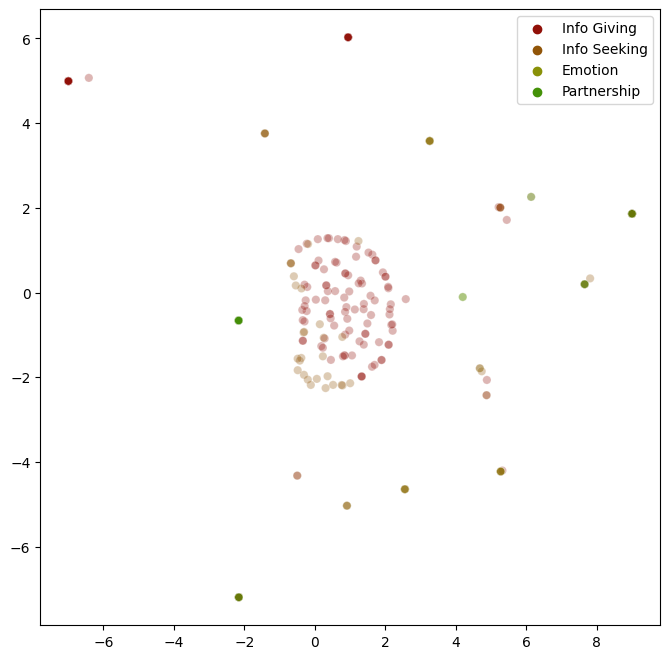

In [30]:
import gc
gc.collect()
tfIdfMatrix = np.asarray(tfIdfMat.todense())
labels = data['Label'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(8,8))
palette = sns.hls_palette(12, l=.3, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

In [31]:
# pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['Label'].tolist()
category_list = np.unique(data['Label'])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels)   
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(202, 12)
Test_Set_Size:(68, 12)


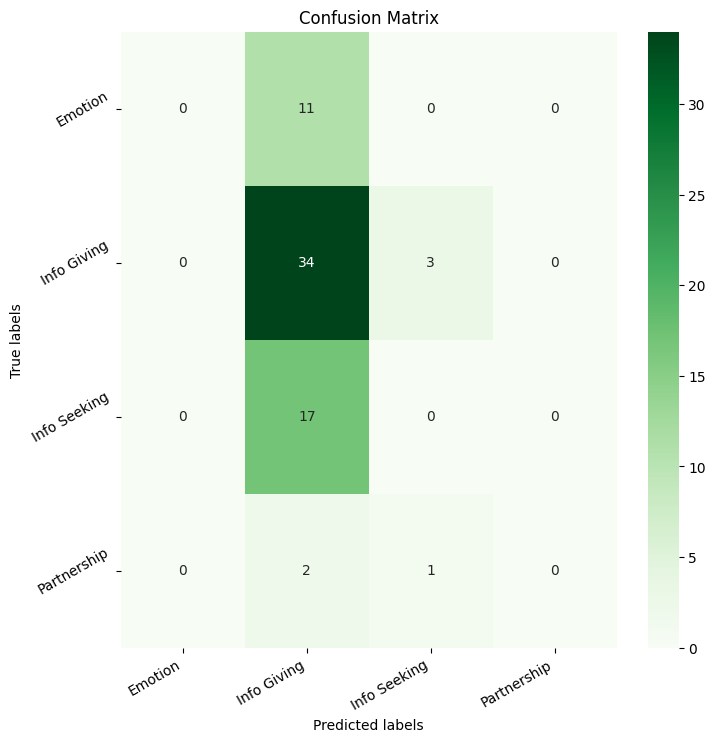

              precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00        11
 Info Giving       0.53      0.92      0.67        37
Info Seeking       0.00      0.00      0.00        17
 Partnership       0.00      0.00      0.00         3

    accuracy                           0.50        68
   macro avg       0.13      0.23      0.17        68
weighted avg       0.29      0.50      0.37        68



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
#clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

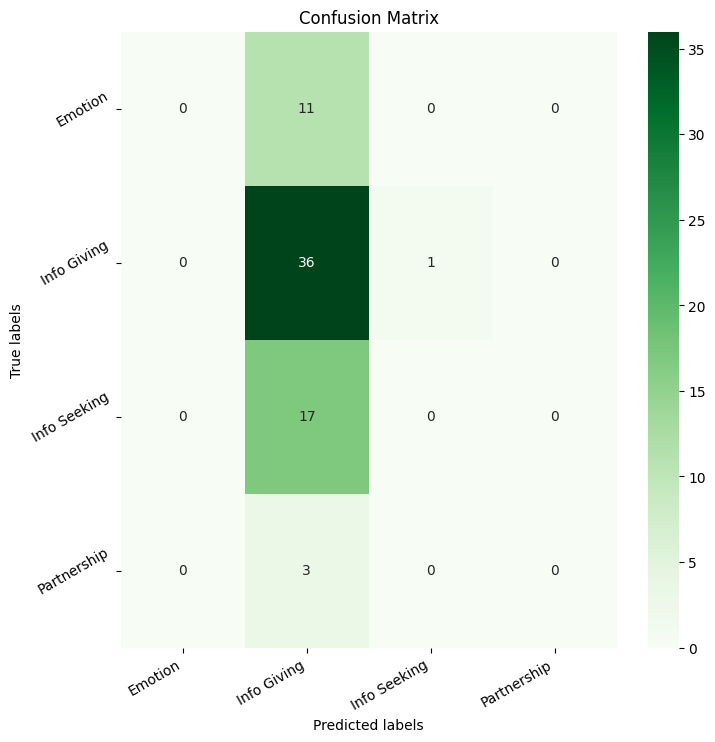

              precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00        11
 Info Giving       0.54      0.97      0.69        37
Info Seeking       0.00      0.00      0.00        17
 Partnership       0.00      0.00      0.00         3

    accuracy                           0.53        68
   macro avg       0.13      0.24      0.17        68
weighted avg       0.29      0.53      0.38        68



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

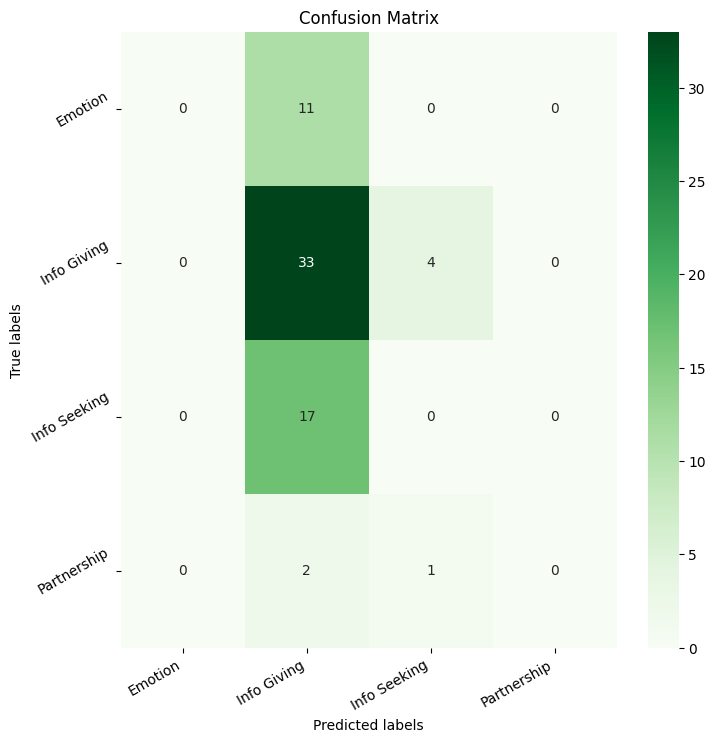

              precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00        11
 Info Giving       0.52      0.89      0.66        37
Info Seeking       0.00      0.00      0.00        17
 Partnership       0.00      0.00      0.00         3

    accuracy                           0.49        68
   macro avg       0.13      0.22      0.16        68
weighted avg       0.29      0.49      0.36        68



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
from sklearn.svm import SVC
clf = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, break_ties=False).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

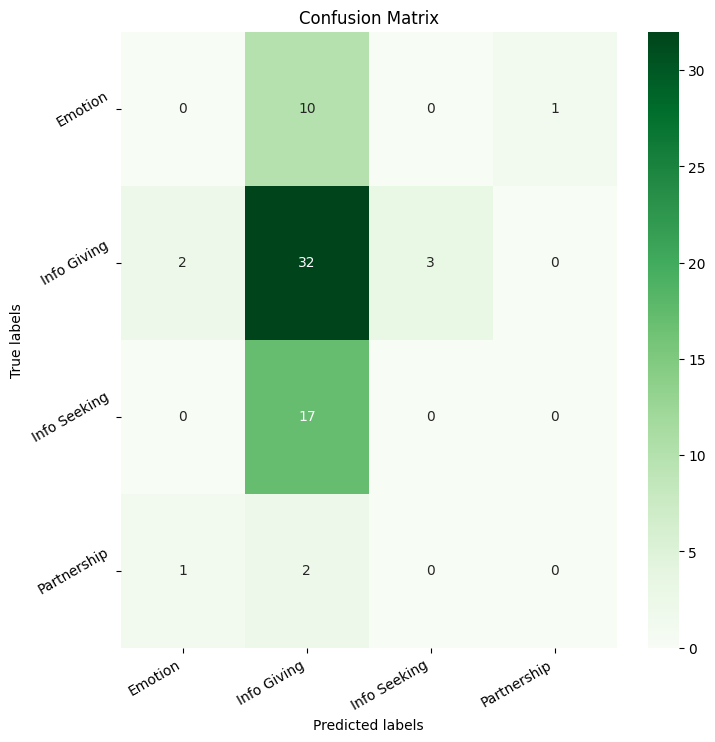

              precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00        11
 Info Giving       0.52      0.86      0.65        37
Info Seeking       0.00      0.00      0.00        17
 Partnership       0.00      0.00      0.00         3

    accuracy                           0.47        68
   macro avg       0.13      0.22      0.16        68
weighted avg       0.29      0.47      0.36        68



In [36]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier().fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

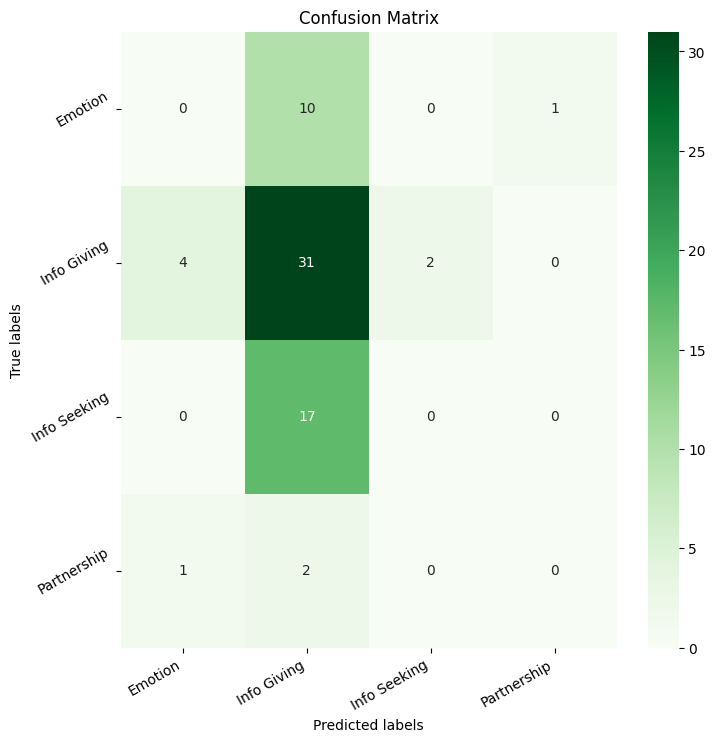

              precision    recall  f1-score   support

     Emotion       0.00      0.00      0.00        11
 Info Giving       0.52      0.84      0.64        37
Info Seeking       0.00      0.00      0.00        17
 Partnership       0.00      0.00      0.00         3

    accuracy                           0.46        68
   macro avg       0.13      0.21      0.16        68
weighted avg       0.28      0.46      0.35        68



In [37]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

fig = plt.figure(figsize=(8,8))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

In [38]:
%pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from gensim.models import Word2Vec
import nltk

In [40]:
data = df
data['Quotation Content'] = data['Quotation Content'].apply(lemmatize_text)
data['Quotation Content'] = data['Quotation Content'].apply(clean_text)
data_list = [sent.split() for sent in data["Quotation Content"]]
model = Word2Vec(data_list, min_count=1, window=5, sg=0)
model.train(data_list, total_examples=len(data), epochs=200)

(25958, 71000)

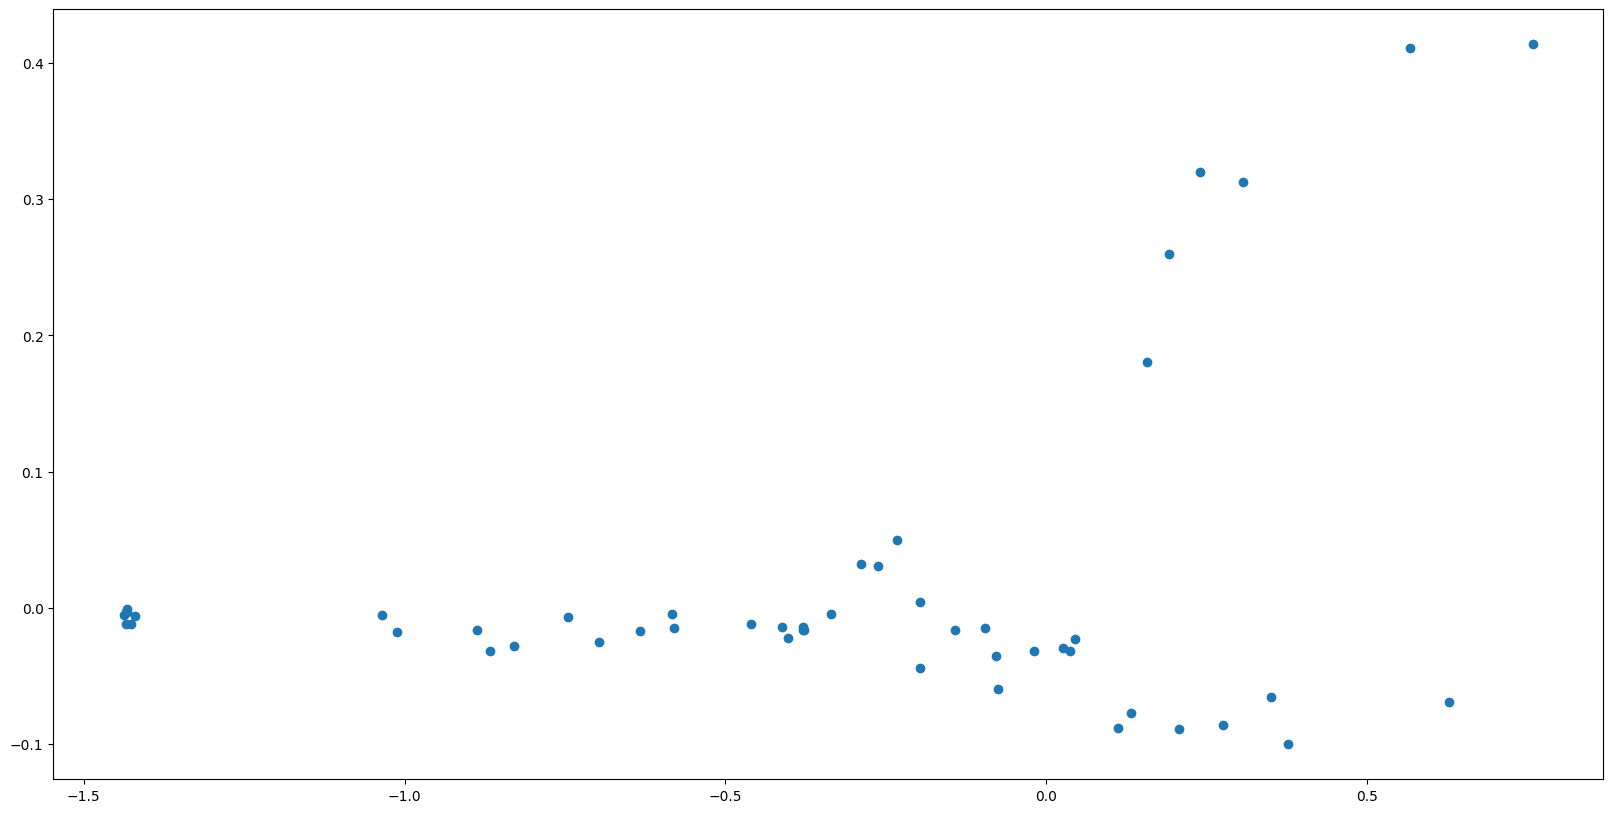

In [41]:
X = model.wv.vectors
pca = PCA(n_components=2)
result = pca.fit_transform(X)

fig = plt.figure(figsize=(20,10))

plt.scatter(result[:50, 0], result[:50, 1])
words = list(model.wv.index_to_key)[450:500]
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=15)
plt.show()